In [ ]:
import numpy as np
from scipy.linalg import hankel, svd
from scipy.io import loadmat
import matplotlib.pyplot as plt 
import scipy.signal as signal
import os 
import pandas as pd 
from scipy.signal import find_peaks
from glob import glob  
import math


os.makedirs('results', exist_ok=True)

In [ ]:
def calculate_snr(S, SN):
    S = S-np.mean(S)
    S = S/np.max(np.abs(S))
    mean_S = (np.sum(S))/(len(S))
    PS = np.sum((S-mean_S)*(S-mean_S))
    PN = np.sum((S-SN)*(S-SN))
    snr=10*math.log((PS/PN), 10)
    return(snr)

def svt_denoise(time_series, window_size, threshold, max_iters=10, k=1):
    n = len(time_series)
    if window_size > n:
        raise ValueError("The window size cannot exceed the length of the time series data.")
    hankel_matrix = hankel(time_series[:window_size], time_series[window_size - 1:])
    for _ in range(max_iters):
        U, sigma, Vt = svd(hankel_matrix, full_matrices=False)
        if len(sigma) > k:
            sigma[-k:] = 0 
        sigma_thresholded = np.maximum(sigma - threshold, 0)
        rank = np.sum(sigma_thresholded > 0)
        hankel_denoised = np.dot(U, np.dot(np.diag(sigma_thresholded), Vt))
        hankel_matrix = hankel_denoised
        if rank < 5: 
            break 
    denoised_series = np.zeros(n)
    count = np.zeros(n)
    for i in range(hankel_denoised.shape[0]):
        for j in range(hankel_denoised.shape[1]):
            denoised_series[i + j] += hankel_denoised[i, j]
            count[i + j] += 1
    denoised_series /= count
    
    return denoised_series, rank

In [ ]:
def find_r_peaks(ecg_signal, sampling_rate=100, height=0.5):
    r_peaks, _ = find_peaks(ecg_signal, height=height, distance=sampling_rate/2)
    r_peaks_times = r_peaks / sampling_rate
    return r_peaks, r_peaks_times


def plot_ecg_with_r_peaks(ecg_signal, sampling_rate=100, height=0.5):
    r_peaks, r_peaks_times = find_r_peaks(ecg_signal, sampling_rate, height=height)
    time = np.arange(0, len(ecg_signal)) / sampling_rate
    plt.figure(figsize=(14, 4))
    plt.plot(time, ecg_signal, label='ECG Signal')
    plt.plot(r_peaks_times, ecg_signal[r_peaks], 'ro', label='R-peaks')
    plt.title('ECG Signal with R-peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

### Simulation data

In [ ]:
os.makedirs('results/simulation', exist_ok=True)
file_path = 'dataset_simulation/signal000.mat'
data = loadmat(file_path)
data.keys()

real_data = data['beat_signal'][0]
dat = data['signal15'][0]

In [ ]:
fs = 100
t = np.linspace(0, 1, 1000, endpoint=False) 
low_cut = 2  
high_cut = 25 
nyquist = fs / 2 
low = low_cut / nyquist
high = high_cut / nyquist
order = 1  
b, a = signal.butter(order, [low, high], btype='band')
filtered_signal = signal.filtfilt(b, a, dat)

In [ ]:
window_size = 200
snrs = {}
ranks = {}
for threshold in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]:
    snrs[threshold] = []
    ranks[threshold] = []
    for max_iters in [5] + list(range(10, 101, 10)):
        denoised_signal, rank = svt_denoise(filtered_signal, window_size, threshold, max_iters=max_iters, k=1)
        after_denoied_db = calculate_snr(real_data, denoised_signal)
        snrs[threshold].append(after_denoied_db)
        ranks[threshold].append(rank)


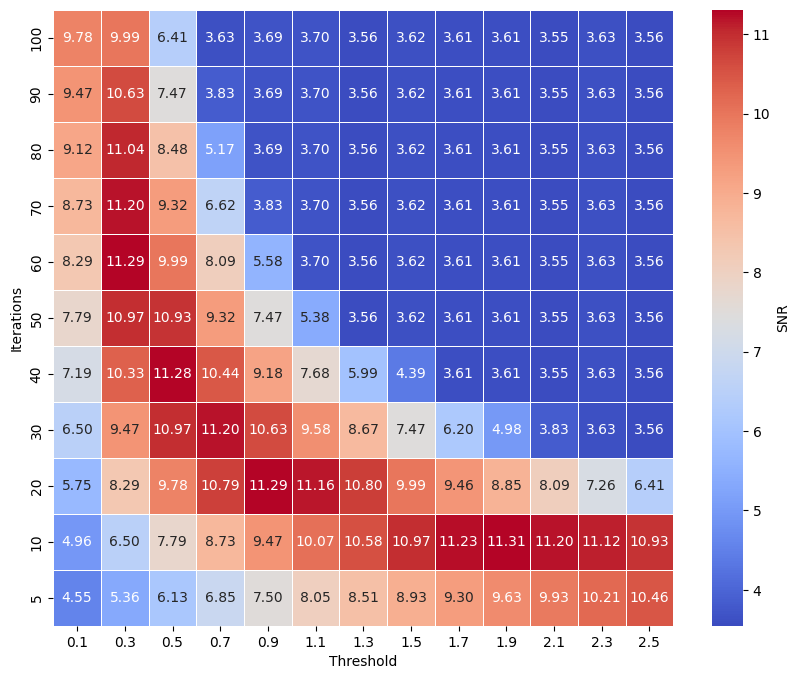

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(snrs)
df.index = [5] + list(range(10, 101, 10))

df = df.sort_index(ascending=False)
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar_kws={'label': 'SNR'})
plt.xlabel('Threshold')
plt.ylabel('Iterations')
plt.savefig('results/SVT_param.pdf')

df.to_csv('results/SVT_parm.csv', index=True)

In [ ]:
window_size = 200
threshold = 1.9
denoised_signal, rank = svt_denoise(filtered_signal, window_size, threshold, max_iters=10, k=1)
print('rank', rank)
before_denoied_db = calculate_snr(real_data, filtered_signal)
after_denoied_db = calculate_snr(real_data, denoised_signal)
print(f"Before Denoised SNR={before_denoied_db:.3f}")
print(f"After Denoised SNR={after_denoied_db:.3f}")

outdir = f'results/simulation/threshold_{threshold}_rank_{rank}/'
os.makedirs(outdir, exist_ok=True)
# save data
pd.DataFrame({'Original_Signal': dat, 
              'Filtered_Signal': filtered_signal, 
              'Denoised_Signal': denoised_signal, 
              'Beat_Signal':data['beat_signal'][0]
              }).to_csv(os.path.join(outdir, 'signal.csv'), index=False)
with open(os.path.join(outdir, 'log.txt'), 'w') as FO:
    FO.writelines(f"Before Denoised SNR={before_denoied_db:.3f}\n")
    FO.writelines(f"After Denoised SNR={after_denoied_db:.3f}\n")


t = np.array(list(range(len(denoised_signal)))) / 100
sigbplots = 4
plt.figure(figsize=(10, 6))
plt.subplot(sigbplots, 1, 1)
plt.plot(t, dat)
plt.title('Original Signal')
plt.ylabel('Amplitude')

plt.subplot(sigbplots, 1, 2)
plt.plot(t, filtered_signal, color='orange')
plt.title('Filtered Signal (2~25Hz)')
plt.ylabel('Amplitude')

plt.subplot(sigbplots, 1, 3)
plt.plot(t, denoised_signal, color='grey')
plt.title('Denoised Signal with SVT')
plt.ylabel('Amplitude')

plt.subplot(sigbplots, 1, 4)
plt.plot(t, data['beat_signal'][0], color='red')
plt.title('Beat Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.savefig(os.path.join(outdir, 'signal.pdf'))

In [ ]:
window_size = 200
threshold = 1
for threshold in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]:
    print('\nthreshold:', threshold)
    denoised_signal, rank = svt_denoise(filtered_signal, window_size, threshold, max_iters=20, k=1)

    before_denoied_db = calculate_snr(real_data, filtered_signal)
    after_denoied_db = calculate_snr(real_data, denoised_signal)
    print(f"Before Denoised SNR={before_denoied_db:.3f}")
    print(f"After Denoised SNR={after_denoied_db:.3f}")
    print('rank', rank)

    outdir = f'results/simulation/threshold_{threshold}_rank_{rank}/'
    os.makedirs(outdir, exist_ok=True)
    # save data
    pd.DataFrame({'Original_Signal': dat, 
                'Filtered_Signal': filtered_signal, 
                'Denoised_Signal': denoised_signal, 
                'Beat_Signal':data['beat_signal'][0]
                }).to_csv(os.path.join(outdir, 'signal.csv'), index=False)
    with open(os.path.join(outdir, 'log.txt'), 'w') as FO:
        FO.writelines(f"Before Denoised SNR={before_denoied_db:.3f}\n")
        FO.writelines(f"After Denoised SNR={after_denoied_db:.3f}\n")
        FO.writelines(f"Rank={rank}\n")


    sigbplots = 4
    plt.figure(figsize=(10, 6))
    plt.subplot(sigbplots, 1, 1)
    plt.plot(t, dat)
    plt.title('Original Signal')
    plt.ylabel('Amplitude')

    plt.subplot(sigbplots, 1, 2)
    plt.plot(t, filtered_signal, color='orange')
    plt.title('Filtered Signal (2~25Hz)')
    plt.ylabel('Amplitude')

    plt.subplot(sigbplots, 1, 3)
    plt.plot(t, denoised_signal, color='grey')
    plt.title('Denoised Signal with SVT')
    plt.ylabel('Amplitude')

    plt.subplot(sigbplots, 1, 4)
    plt.plot(t, data['beat_signal'][0], color='red')
    plt.title('Beat Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'signal.pdf'))

### Human Dataset

In [ ]:
def preprocess_bcg(bcg, ecg, human_id, threshold=10, rank=None):
    t = np.array(list(range(len(bcg)))) / 100
    window_size = 200
    threshold = 1.9
    denoised_signal, rank = svt_denoise(bcg, window_size, threshold, max_iters=10, k=1)
    print(denoised_signal.shape)
    outdir = f'results/human/{human_id}/'
    os.makedirs(outdir, exist_ok=True)
    # save data
    pd.DataFrame({'Original_BCG_Signal': bcg, 
                'ecg': ecg, 
                'Denoised_BCG_Signal': denoised_signal
                }).to_csv(os.path.join(outdir, 'signal.csv'), index=False)

    sigbplots = 3
    plt.figure(figsize=(10, 6))
    plt.subplot(sigbplots, 1, 1)
    plt.plot(t, bcg)
    plt.title('BCG Original Signal')
    plt.ylabel('Amplitude')

    # plt.subplot(sigbplots, 1, 2)
    # plt.plot(t, filtered_signal, color='orange')
    # plt.title('BCG Filtered Signal (2~25Hz)')
    # plt.ylabel('Amplitude')

    plt.subplot(sigbplots, 1, 2)
    plt.plot(t, denoised_signal, color='grey')
    plt.title('BCG Denoised Signal with SVT')
    plt.ylabel('Amplitude')

    plt.subplot(sigbplots, 1, 3)
    plt.plot(t, ecg, color='red')
    plt.title('ECG Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')


    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'signal.pdf'))
    
    return denoised_signal


def plot_ecg_with_r_peaks(ecg_signal, sampling_rate=100, height=0.5, human_id='Id'):
    r_peaks, r_peaks_times = find_r_peaks(ecg_signal, sampling_rate, height=height)
    time = np.arange(0, len(ecg_signal)) / sampling_rate
    plt.figure(figsize=(14, 4))
    plt.plot(time, ecg_signal, label='ECG Signal')

    plt.plot(r_peaks_times, ecg_signal[r_peaks], 'ro', label='R-peaks')
    
    plt.title('ECG Signal with R-peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()
    return r_peaks, r_peaks_times

In [ ]:
files = glob('dataset_hm/*mat')
print('Sample Number: ', len(files))

for infile in files:
    data = loadmat(infile)
    bcg = data['beat'].flatten()
    ecg = data['v2'].flatten()

    if np.sum(ecg == 0) == len(ecg):
        continue

    if len(ecg) != len(bcg):
        continue
    human_id = os.path.basename(infile).split('.')[0]
    denoised_signal = preprocess_bcg(bcg, ecg, human_id)



In [ ]:
human_ids = os.listdir('results/human')
idx = 159
human_id = human_ids[idx]

df = pd.read_csv(f'results/human/{human_id}/signal.csv')
ecg = df.ecg.values
denoised_signal = df.Denoised_BCG_Signal.values

bcg_peaks, bcg_peaks_times = plot_ecg_with_r_peaks(denoised_signal, height=0.0)
pd.DataFrame({'BCG_Peark_Point': bcg_peaks, 
            'BCG_Peark_Times': bcg_peaks_times, 
            }).to_csv(f'results/human/{human_id}/{human_id}_BCG.csv', index=False)
print(len(bcg_peaks))

ecg_peaks, ecg_peaks_times = plot_ecg_with_r_peaks(ecg, height=0.31)
pd.DataFrame({'ECG_Peark_Point': ecg_peaks, 
            'ECG_Peark_Times': ecg_peaks_times, 
            }).to_csv(f'results/human/{human_id}/{human_id}_ECG.csv', index=False)

print(len(ecg_peaks))

### Analyze the results

In [410]:
bcg_files = glob('results/human/*/*BCG.csv')
ecg_files = glob('results/human/*/*ECG.csv')

In [411]:
bcg_preak_numbers = [pd.read_csv(infile).shape[0] for infile in bcg_files]
ecg_preak_numbers = [pd.read_csv(infile).shape[0] for infile in ecg_files]

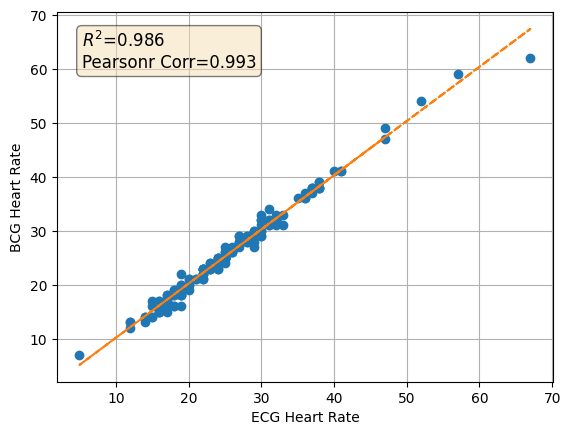

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

fit = np.polyfit(ecg_preak_numbers, bcg_preak_numbers, deg=1)
predicted = np.polyval(fit, ecg_preak_numbers)

r2 = r2_score(bcg_preak_numbers, predicted)
correlation, _ = pearsonr(ecg_preak_numbers, bcg_preak_numbers)

plt.plot(ecg_preak_numbers, bcg_preak_numbers, 'o', label='Data points')
plt.plot(ecg_preak_numbers, predicted, '--', label=f'Fit line: y={fit[0]:.2f}x+{fit[1]:.2f}')
plt.text(0.05, 0.95, f'$R^2$={r2:.3f}\nPearsonr Corr={correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
# plt.legend()
plt.xlabel('ECG Heart Rate')
plt.ylabel('BCG Heart Rate')
# plt.title('Scatter Plot with R2 and Correlation')
plt.grid(True)
plt.savefig('results/fig1.pdf')
pd.DataFrame({'ecg_preak_numbers': ecg_preak_numbers,
              'bcg_preak_numbers': bcg_preak_numbers
              }).to_csv('results/heart_rate_numbers.csv', index=False)

In [386]:
total_diff_times = []
for idx,_ in enumerate(bcg_files):
    tb1 = pd.read_csv(bcg_files[idx])
    tb2 = pd.read_csv(ecg_files[idx])
    diff_times = [np.min(np.abs(t - tb2.ECG_Peark_Times.values)) for t in tb1.BCG_Peark_Times.values]
    total_diff_times.extend(diff_times)

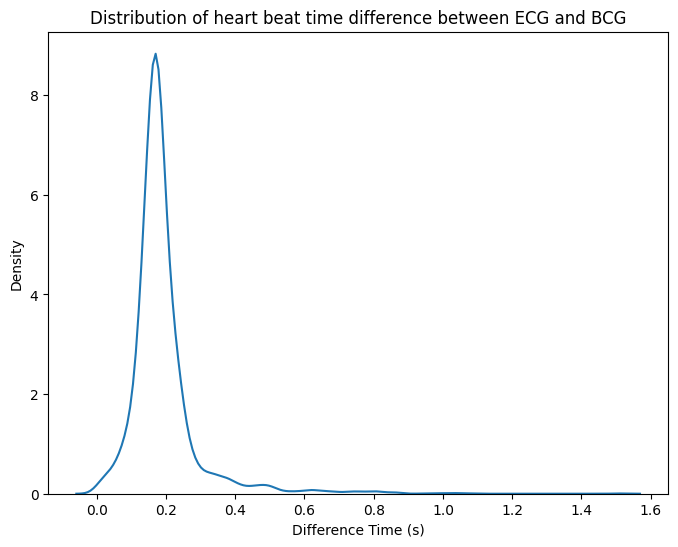

In [406]:
import seaborn as sns 

plt.figure(figsize=(8,6))
sns.kdeplot(total_diff_times)
plt.xlabel('Difference Time (s)')
plt.title('Distribution of heart beat time difference between ECG and BCG')
plt.savefig('results/fig2.pdf')
np.savetxt('results/Difference_Time.txt', total_diff_times)

In [ ]:
total_diff_times = []
for idx,_ in enumerate(bcg_files):
    tb1 = pd.read_csv(bcg_files[idx])
    tb2 = pd.read_csv(ecg_files[idx])
    diff_times = [np.min(np.abs(t - tb2.ECG_Peark_Times.values)) for t in tb1.BCG_Peark_Times.values]
    total_diff_times.extend(diff_times)

In [399]:
bcg_times = []
ecg_times = []
for idx,_ in enumerate(bcg_files):
    tb1 = pd.read_csv(bcg_files[idx])
    tb2 = pd.read_csv(ecg_files[idx])
    for t in tb1.BCG_Peark_Times.values:
        i = np.argmin(np.abs(t - tb2.ECG_Peark_Times.values))
        bcg_times.append(t)
        ecg_times.append(tb2.ECG_Peark_Times.values[i])

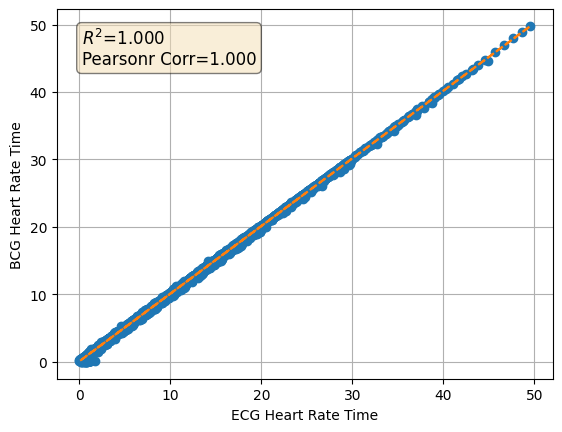

In [ ]:
fit = np.polyfit(ecg_times, bcg_times, deg=1)
predicted = np.polyval(fit, ecg_times)

r2 = r2_score(bcg_times, predicted)
correlation, _ = pearsonr(ecg_times, bcg_times)

plt.plot(ecg_times, bcg_times, 'o', label='Data points')
plt.plot(ecg_times, predicted, '--', label=f'Fit line: y={fit[0]:.2f}x+{fit[1]:.2f}')
plt.text(0.05, 0.95, f'$R^2$={r2:.3f}\nPearsonr Corr={correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

# plt.legend()
plt.xlabel('ECG Heart Rate Time')
plt.ylabel('BCG Heart Rate Time')
# plt.title('Scatter Plot with R2 and Correlation')
plt.grid(True)
plt.savefig('results/fig3.pdf')

pd.DataFrame({'ecg_times': ecg_times,
              'bcg_times': bcg_times
              }).to_csv('results/heart_rate_times.csv', index=False)